# Import libraries

In [1]:
%pylab notebook
from __future__ import print_function
import datacube
import pandas as pd
import xarray as xr
from datetime import date, timedelta
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets
import rasterio
from datacube_stats.statistics import GeoMedian
from osgeo import *
from gdal import *


import gdal
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import write_geotiff


dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')

Populating the interactive namespace from numpy and matplotlib


# User requirement: specifiy location of interest and date of cyclone

In [126]:
###User input: enter area of interest
lat_min = -20.385 #down
lat_max = -20.326 #up
lon_min = 148.916 #left
lon_max = 148.984 #right
   
###User input: enter start and end date of cyclone
start_of_event= '2017-03-23'
end_of_event= '2017-04-07'

###User input:enter the name of cyclone
cyclone_name =  'Yasi'

###User input: enter the directory location of input data
input_folder = '/g/data/w85/ext547/input_data/'

###User input : enter the directory location of output data. Please enter again if the same as input_folder.
output_folder = '/g/data/w85/ext547/output_data/'

 # No more user requirements. Just run remaining cells.

In [3]:
# Temporal range and bands of interest are defined

#Define temporal range
start_of_epoch = '2000-01-01'
end_of_epoch =  '2017-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['green',
                     'red', 
                     'nir',
                     'swir1']

#Define sensors of interest, # out sensors that aren't relevant for the time period
sensors = ['ls8', #May 2013 to present
    'ls7', #1999 to present
    'ls5' #1986 to present, full contintal coverage from 1987 onwards
    ] 


#Build query
query = {'time': (start_of_epoch, end_of_epoch),}  
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print(query)

{'time': ('2000-01-01', '2017-12-31'), 'x': (148.916, 148.984), 'y': (-20.326, -20.385), 'crs': 'EPSG:4326'}


In [4]:
#reformat event date format 

start_of_event=datetime.datetime.strptime(start_of_event,'%Y-%m-%d') #Convert to datetime
end_of_event=datetime.datetime.strptime(end_of_event,'%Y-%m-%d') #Convert to datetime

# Extract information from Open Data Cube

In [5]:
#Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results.

mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True,
'land_sea':'land'}

In [6]:
#Retrieve the data for each Landsat sensor

sensor_clean = {}
cloud_free_threshold = 0.80  ###User modification: set cloud threshold. Default value is "0.90" or >90% image and <10% cloud cover
                        ###Scenes will not be retrieved that have less than the cloud threshold worth of image.

for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
                          measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
                        fuse_func=ga_pq_fuser, **query)
    
    #Retrieve the projection information before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    
    #Ensure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    
    #Apply the PQ masks to the NBAR
    quality_mask = masking.make_mask(sensor_pq, **mask_components)
    good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar2 = sensor_nbar.where(good_data)
    
    #Calculate the percentage cloud free for each scene
    cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
                                   contiguous=True).pixelquality
    mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
        
    #Discard data that does not meet the cloud_free_threshold
    mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')
    mostly_good['product'] = ('time', numpy.repeat(sensor, mostly_good.time.size))    
    sensor_clean[sensor] = mostly_good

    print('loaded %s' % sensor) 
    

print ('complete')

loaded ls8
loaded ls7
loaded ls5
complete


In [7]:
#Check the output

sensor_clean

{'ls5': <xarray.Dataset>
 Dimensions:  (time: 58, x: 315, y: 299)
 Coordinates:
   * time     (time) datetime64[ns] 2003-07-17T23:41:17.500000 ...
   * y        (y) float64 -2.297e+06 -2.297e+06 -2.297e+06 -2.297e+06 ...
   * x        (x) float64 1.751e+06 1.751e+06 1.751e+06 1.751e+06 1.751e+06 ...
 Data variables:
     green    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     red      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     nir      (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     swir1    (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
     product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' ...
 Attributes:
     crs:      EPSG:3577, 'ls7': <xarray.Dataset>
 Dimensions:  (time: 147, x: 315, y: 299)
 Coordinates:
   * time     (time) datetime64[ns] 2000-01-06T23:57:40.500000 ...
   * y        (y) float64 -2.297e+06 -2.297e+06 -2.297e+06 -2.297e+06 ...
   * x        (x) float64 1.7

In [8]:
#Concatenate (join) data from different sensors together and sort so that observations are sorted 
#by time rather than sensor

nbar_clean = xr.concat(sensor_clean.values(), 'time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine

In [9]:
nbar_clean=nbar_clean.drop('product')

In [10]:
#Check that the concatenation worked

nbar_clean.isel(time=240)

<xarray.Dataset>
Dimensions:  (x: 315, y: 299)
Coordinates:
  * y        (y) float64 -2.297e+06 -2.297e+06 -2.297e+06 -2.297e+06 ...
  * x        (x) float64 1.751e+06 1.751e+06 1.751e+06 1.751e+06 1.751e+06 ...
    time     datetime64[ns] 2017-03-02T00:04:41
Data variables:
    green    (y, x) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
    red      (y, x) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
    nir      (y, x) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
    swir1    (y, x) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 25.00, 0.00, 1751300.00|\n| 0.00,-25.00,-2296525.00|\n| 0.00,...

# Landscape and NDVI of scene prior to cyclone

In [11]:
#Prepare imagery for scene before cyclone

rgb = nbar_clean.isel(time =240).to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')

# rgb = nbar_clean.sel(time =start_of_event, method = 'pad').to_array(dim='color').sel(color=[
#     'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


In [12]:
#Create image that shows landscape before cyclone

fig = plt.figure(figsize =(8,8)) #Edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions
fig.patch.set_facecolor('white') #Make border white 
fig.patch.set_alpha(0.99)#Ensure border white
plt.axis('off')#remove axis 
plt.title('Image 01: landscape just prior to cyclone') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image
plt.show() #show image

<IPython.core.display.Javascript object>

In [13]:
#Calculate NDVI
ndvi = ((nbar_clean.nir-nbar_clean.red)/(nbar_clean.nir+nbar_clean.red))
ndvi.attrs['crs'] = crs
ndvi.attrs['affine'] = affine

ndvi01= ndvi.isel(time =240) #NDVI for scene just prior to cyclone

#ndvi01= ndvi.sel(time =start_of_event, method = 'pad') #NDVI for scene just prior to cyclone

In [14]:
#Plot NDVI for scene prior to cyclone

#Controls for NDVI colour map
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

#Create plot
fig = plt.figure() #create plot
plt.title('NDVI 01: before event') #add title
i=plt.imshow(ndvi01,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm) #create image with colourbar
fig.colorbar(i) #add colour bar

<IPython.core.display.Javascript object>

# Landscape and NDVI of scene after cyclone

In [15]:
#Prepare imagery for scene after cyclone

rgb02 = nbar_clean.isel(time =244).to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')

# rgb02 = nbar_clean.sel(time =end_of_event, method = 'backfill').to_array(dim='color').sel(color=[
#     'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb02 = rgb02.astype('double')
clipped_visible02 = rgb02.where(rgb02<fake_saturation).fillna(fake_saturation)
max_val02 = clipped_visible02.max(['y', 'x'])
scaled02 = (clipped_visible02 / max_val02)

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


<IPython.core.display.Javascript object>


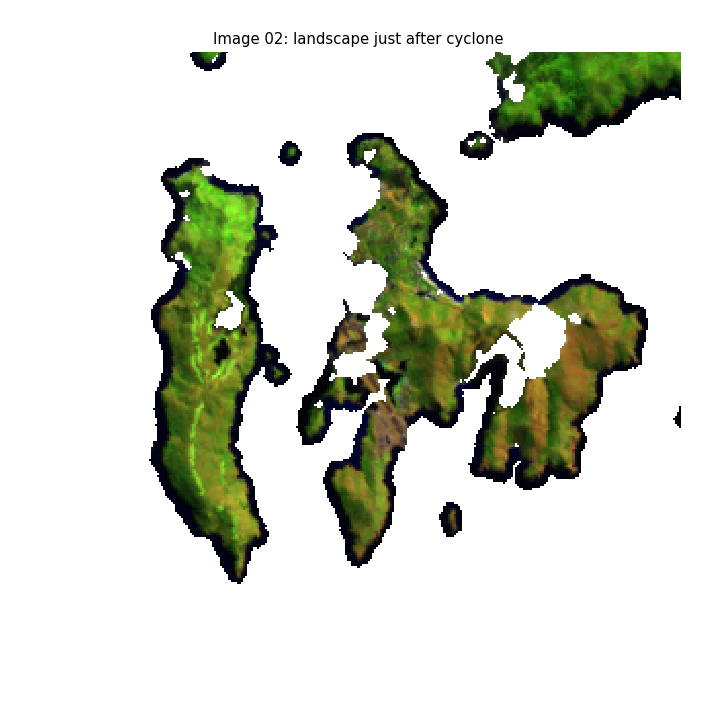

In [138]:
#Create image that shows landscape after cyclone

fig = plt.figure(figsize =(8,8)) #Edit size of plot
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions
fig.patch.set_facecolor('white') #Make border white
fig.patch.set_alpha(0.99)#Ensure border white
plt.axis('off')#remove axis
plt.title('Image 02: landscape just after cyclone') #add title
plt.imshow(scaled02, interpolation = 'nearest') #create image
plt.show() #show image

In [139]:
#Select NDVI for scene after cyclone
ndvi02= ndvi.isel(time =244)
# ndvi02= ndvi.sel(time =end_of_event, method = 'backfill')

<IPython.core.display.Javascript object>


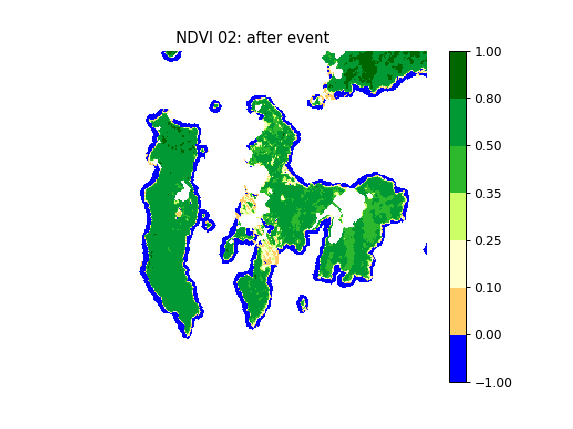

In [140]:
#Plot NDVI for scene after cyclone
fig = plt.figure() #create plot
plt.title('NDVI 02: after event' ) #add title
plt.axis('off')#remove axis
i=plt.imshow(ndvi02,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm) #create image with colourbar
fig.colorbar(i) #add colourbar

# Change in vegetation before/after cyclone

In [44]:
#Calculate the difference in NDVI from before to after cyclone
ndvi_change= ndvi02-ndvi01
ndvi_change.attrs['affine'] = affine
# ndvi_change=(((ndvi_change-np.amin(ndvi_change))/(np.amax(ndvi_change)-np.amin(ndvi_change)))*100)

In [45]:
ndvi_change

<xarray.DataArray (y: 299, x: 315)>
array([[      nan,       nan,       nan, ..., -0.069888, -0.06527 , -0.114419],
       [      nan,       nan,       nan, ..., -0.079016, -0.048407, -0.09146 ],
       [      nan,       nan,       nan, ..., -0.086008, -0.072053, -0.113373],
       ..., 
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]])
Coordinates:
  * y        (y) float64 -2.297e+06 -2.297e+06 -2.297e+06 -2.297e+06 ...
  * x        (x) float64 1.751e+06 1.751e+06 1.751e+06 1.751e+06 1.751e+06 ...
Attributes:
    affine:   | 25.00, 0.00, 1751300.00|\n| 0.00,-25.00,-2296525.00|\n| 0.00,...

<IPython.core.display.Javascript object>


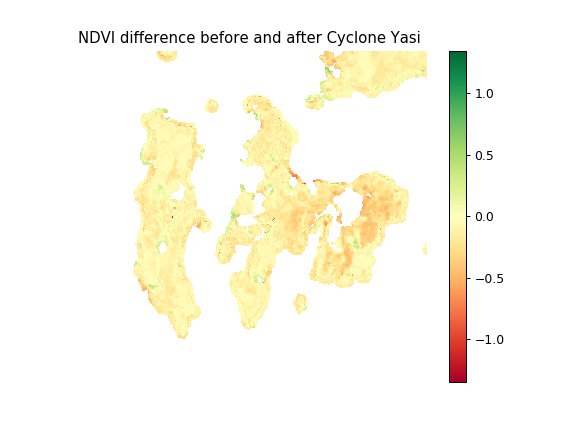

In [128]:
#Plot the change of NDVI
fig = plt.figure() #create plot
ndvi_change.plot(cmap = 'RdYlGn') #create image
plt.title('NDVI difference before and after Cyclone '+str(cyclone_name)) #add title
plt.axis('off')#remove axis
plt.show() #show image

# Import and process windfield data to ensure pixel size and projection is the same as NDVI dataset

In [92]:
#read windfield geotiff
windfield = gdal.Open(input_folder+'Final_corrected_TCDebbie_wind.tif', gdal.GA_ReadOnly)
windfield

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc4dfd96030> >

In [93]:
#get projection information from windfiled
windfield_proj = windfield.GetProjection()
windfield_proj

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]'

In [98]:
#Convert NDVI data array to raster saved in memory

#save NDVI_change dataset to a numpy array
ndvi_array = np.asarray(ndvi_change)

#define conversion variables
cols= int(ndvi_change.x.count())
rows= int(ndvi_change.y.count())
originX= ndvi_change.affine.c
dx= ndvi_change.affine.a
originY= ndvi_change.affine.f
dy= ndvi_change.affine.e
epsg=int((str(crs)).replace('EPSG:',''))
nodata=0

#complete conversion of NDVI array into raster
driver = gdal.GetDriverByName('MEM')
ndvi_raster = driver.Create('ndvi', cols, rows, 1, gdal.GDT_Float32)
ndvi_raster.SetGeoTransform((originX, dx, 0, originY, 0, dy))
ndvi_band = ndvi_raster.GetRasterBand(1)
ndvi_band.WriteArray(ndvi_array)
ndvi_band.SetNoDataValue(nodata)
ndvi_raster_SRS = osr.SpatialReference()
ndvi_raster_SRS.ImportFromEPSG(epsg)
ndvi_raster.SetProjection(ndvi_raster_SRS.ExportToWkt())
ndvi_band.FlushCache()

In [99]:
#Save metadata from NDVI_change
match_ds = ndvi_raster
match_proj = match_ds.GetProjection()
match_geotrans = match_ds.GetGeoTransform()
wide = match_ds.RasterXSize
high = match_ds.RasterYSize

In [134]:
#Create a  geotiff that is the same size and is in the same projection as the NDVI dataset
drv = gdal.GetDriverByName('GTiff')
windfield_matched = drv.Create('ouput_file', wide, high, 1, gdal.GDT_Float32)
windfield_matched.SetGeoTransform(match_geotrans)
windfield_matched.SetProjection(match_proj)

#create windfield geotiff
resampling_method = gdalconst.GRA_Bilinear
gdal.ReprojectImage(windfield, windfield_matched, windfield_proj, match_proj, resampling_method)

#view datasets and projections to ensure information looks correct
print ('windfield       = ', windfield)
print ('windfield_matched             = ',windfield_matched)
print ('windfield_proj        = ',windfield_proj)
print ('match_proj      = ',match_proj)

windfield       =  <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc4dfd96030> >
windfield_matched             =  <osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fc4e058ac30> >
windfield_proj        =  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]
match_proj      =  PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER["longitude_

# Save resampled windfield as an array and check array shape

In [136]:
windfield_matched_array=windfield_matched.ReadAsArray()

print('windfield shape = '+ str(shape(windfield_matched_array)))
print('ndvi_change shape = '+ str(shape(ndvi_change.values)))

windfield shape = (299, 315)
ndvi_change shape = (299, 315)


# Create a plot that examines relationship between wind and change in NDVI after a cyclone

<IPython.core.display.Javascript object>


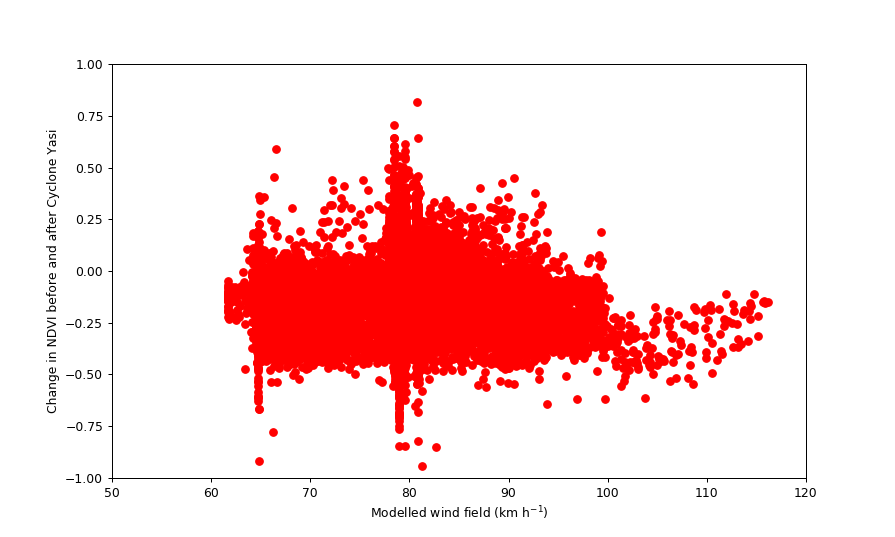

In [137]:
fig = plt.figure(figsize=(10,6))
plt.plot(windfield_matched_array, ndvi_change.values, 'ro') 
plt.axis([50 , 120 ,-1.0, 1.0], 'tight')
plt.xlabel('Modelled wind field (km h$^{-1}$)') #Set X label
plt.ylabel('Change in NDVI before and after Cyclone '+str(cyclone_name)) #Set Y label

plt.show()

In [63]:
# #Controls for TCRM colour map
# tcrm_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
# tcrm_bounds = [-1, 0, 10, 30, 45, 60, 75, 91]
# tcrm_norm = mpl.colors.BoundaryNorm(tcrm_bounds, tcrm_cmap.N)

In [37]:
# #read windfield geotiff
# ds = gdal.Open('/g/data/w85/ext547/TCRM_corrected1.tif', gdal.GA_ReadOnly)
# # plt.imshow(TCRM)
# # plt.show()
# myarray = xr.DataArray(ds.GetRasterBand(1).ReadAsArray())


# fig = plt.figure()
# myarray.plt.imshow(interpolation = 'nearest', cmap = tcrm_cmap, norm = tcrm_norm, levels=tcrm_bounds) #create image with colourbar
# myarray.fig.colorbar() #add colour bar

In [38]:
# src=tempRaster

In [39]:
# #read ndvi geotiff
# ndvi_tif = gdal.Open('/g/data/w85/ext547/cyclone_repo/test.tif', gdal.GA_ReadOnly)
# ndvi_tif

In [40]:
# ndvi_proj = ndvi_tif.GetProjection()
# ndvi_proj

# save ndvi information as a geotiff

In [41]:
# def write_geotiff(filename, dataset, time_index=None, profile_override=None):
#     """
#     Write an xarray dataset to a geotiff
#     :attr bands: ordered list of dataset names
#     :attr time_index: time index to write to file
#     :attr dataset: xarray dataset containing multiple bands to write to file
#     :attr profile_override: option dict, overrides rasterio file creation options.
#     """
#     profile_override = profile_override or {}

#     dtypes = {val.dtype for val in dataset.data_vars.values()}
#     assert len(dtypes) == 1  # Check for multiple dtypes

#     profile = DEFAULT_PROFILE.copy()
#     profile.update({
#         'width': dataset.dims['x'],
#         'height': dataset.dims['y'],
#         'affine': dataset.affine,
#         #'crs': dataset.crs.crs_str,
#         'crs': dataset.crs,
#         'count': len(dataset.data_vars),
#         'dtype': str(dtypes.pop())
#     })
#     profile.update(profile_override)

#     with rasterio.open(filename, 'w', **profile) as dest:
#         for bandnum, data in enumerate(dataset.data_vars.values(), start=1):
#             #dest.write(data.isel(time=time_index).data, bandnum)
#             dest.write(data, bandnum)
#             print ('Done')

In [ ]:
# ndvi_dataset = np.asarray(ndvi_change)
# ndvi_dataset

In [ ]:
# type(tempRaster)

In [ ]:
# ndvi_change.affine

In [ ]:
# ndvi_tiff.attrs['affine'] = affine
# ndvi_tiff.attrs['crs'] = crs.wkt

# ndvi_tiff

In [ ]:
# DEFAULT_PROFILE = {
#     'blockxsize': 128,
#     'blockysize': 128,
#     'compress': 'lzw',
#     'driver': 'GTiff',
#     'interleave': 'band',
#     'nodata': 0.0,
#     'photometric': 'RGBA',
#     'tiled': True}

In [ ]:
# outfile = '/g/data/w85/ext547/cyclone_repo/ndvi_tiff.tif'

# write_geotiff(outfile, ndvi_tiff)

In [103]:
# import regionmask

In [104]:
# x = xr.open_dataset('/home/547/ext547/Downloads/landmask.nc')
# x.landmask.values[:,:] = x.landmask.values[::-1,:]
# x.landmask.values[x.landmask.values== 0] = 'nan'
# x.landmask.values[x.landmask.values== 3] = 1
# ndvi_masked=ndvi_change.values * x.landmask.values 

In [105]:
# ndvi_masked=masking.DataArray(ndvi_change)
# ndvi_masked

In [106]:
# fig = plt.figure()
# x['landmask'].plot.imshow()